In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys
import graphviz 
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')
    
import file_utils
import utils
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn import tree
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)
print("sklearn version: ", sklearn.__version__)

Seaborn version:  0.9.0
sklearn version:  0.20.2


In [2]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [4]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [5]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


In [8]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(tourney_data, teams, game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor


In [9]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,win_pts,lose_pts,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,14.05,6.11,0.697,81.0,73.0,0.458,0.774,85.363636,11.0,24.0,15.0,7.0,94.888179,20.0,11.00,5.25,0.758,66.0,60.0,0.451,0.711,71.333333,10.0,23.0,12.0,4.0,92.523364,18.0,30,43.0,33,36,32.0,42.0,29.0,50.0,27,38,31.0,25,34,20.0,37.0,33.0,16.0,66,0,0,0,8.0,6.0,2.0,0.007,1.0,1.0,0.063,8.0,8.0,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,34.0,-39
1,2003,85,55,18.54,7.76,0.758,75.0,64.0,0.476,0.703,76.945455,10.0,24.0,13.0,7.0,97.471645,18.0,-1.65,-6.87,0.767,72.0,65.0,0.459,0.705,79.620000,11.0,25.0,15.0,8.0,90.429540,23.0,7,11.0,11,10,14.0,6.0,8.0,15.0,7,138,102.0,115,143,87.0,134.0,93.0,91.0,169,1,0,1,11.0,7.0,4.0,0.017,-1.0,-1.0,-0.002,6.0,7.0,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-76.0,-162
2,2003,68,62,16.96,6.96,0.806,77.0,67.0,0.453,0.752,83.167742,14.0,26.0,15.0,6.0,92.583973,26.0,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,9,9.0,4,7,8.0,12.0,4.0,7.0,20,43,47.0,40,40,44.0,45.0,43.0,36.0,44,0,0,1,10.0,5.0,5.0,-0.012,2.0,3.0,0.092,9.0,8.0,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-29.0,-24
3,2003,65,63,12.68,8.34,0.647,70.0,65.0,0.465,0.660,79.558824,12.0,23.0,15.0,7.0,87.985213,20.0,14.61,3.71,0.767,70.0,59.0,0.443,0.686,75.666667,11.0,24.0,12.0,7.0,92.511013,20.0,43,47.0,40,40,44.0,45.0,43.0,36.0,44,20,16.0,27,28,27.0,18.0,22.0,27.0,38,1,0,0,5.0,11.0,-6.0,0.022,1.0,-1.0,-0.026,8.0,5.0,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,9.0,6
4,2003,95,84,18.91,9.27,0.788,79.0,69.0,0.446,0.721,85.248485,16.0,25.0,13.0,6.0,92.670269,24.0,19.02,9.02,0.857,79.0,69.0,0.475,0.694,84.640000,13.0,27.0,14.0,8.0,93.336484,23.0,5,7.0,7,6,4.0,7.0,7.0,4.0,12,12,14.0,5,12,9.0,15.0,5.0,9.0,21,0,0,0,10.0,10.0,0.0,-0.029,3.0,-2.0,0.027,7.0,6.0,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-5.0,-9


In [10]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)



# for now drop the delta seed features
feature_data.drop(columns=['upset_seed_threshold'], inplace=True)
feature_data.head()

,season_t,win_pts,lose_pts,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2003,60,58,0,0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1,3.05,0.86,-8,12.0,8,2,12.0,5.0,-4.0,34.0,-39
1,2003,85,55,1,0,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13,20.19,14.63,-131,-91.0,-104,-133,-73.0,-128.0,-85.0,-76.0,-162
2,2003,68,62,0,0,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8,4.28,-1.38,-34,-38.0,-36,-33,-36.0,-33.0,-39.0,-29.0,-24
3,2003,65,63,1,0,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3,-1.93,4.63,23,31.0,13,12,17.0,27.0,21.0,9.0,6
4,2003,95,84,0,0,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2,-0.11,0.25,-7,-7.0,2,-6,-5.0,-8.0,2.0,-5.0,-9


In [11]:
X= feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['win_pts',
 'lose_pts',
 'top_conf_t',
 'top_conf_o',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

####  Train Validate Test

In [12]:
X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
X_train_1, X_validate, y_train_1, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=0.25, random_state = 5)
print("Total games= ", X.shape[0])
print("X Train_1: ",X_train_1.shape)
print("y_train_1", y_train_1.shape)
print("X Validate: ",X_validate.shape)
print("y_validate", y_validate.shape)
print("X Test: ",X_test.shape)
print(y_test.shape)

Total games=  978
X Train_1:  (586, 25)
y_train_1 (586,)
X Validate:  (196, 25)
y_validate (196,)
X Test:  (196, 25)
(196,)


In [13]:
number_estimators = 201
algorithm_choice = "SAMME.R"
ada= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm=algorithm_choice, n_estimators=number_estimators)
    
ada.fit(X_train_1, y_train_1)
score = ada.score(X_train_1, y_train_1)
print("Training Model Score= ", score)


Training Model Score=  0.9897610921501706


In [14]:
param_grid ={
    "n_estimators": [51,101,201,301,401,501,601],
    "learning_rate": [0.01, .05, .1, .5, 1,5]
}

grid_search = GridSearchCV( AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm=algorithm_choice), 
                           param_grid=param_grid, cv=5)

start = time()
grid_search.fit(X_validate, y_validate)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


GridSearchCV took 58.67 seconds for 42 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.740 (std: 0.065)
Parameters: {'learning_rate': 5, 'n_estimators': 51}

Model with rank: 2
Mean validation score: 0.730 (std: 0.124)
Parameters: {'learning_rate': 5, 'n_estimators': 201}

Model with rank: 2
Mean validation score: 0.730 (std: 0.079)
Parameters: {'learning_rate': 5, 'n_estimators': 601}



C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
number_estimators = 501

ada= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm=algorithm_choice, n_estimators=number_estimators,
                       learning_rate = 1)

X_train = pd.concat([X_train_1, X_validate])
y_train = pd.concat([y_train_1, y_validate])
print("X Train: ",X_train.shape)
print(y_train.shape)

ada.fit(X_train, y_train)
score = ada.score(X_train, y_train)
print("Training Model Score= ", score)

X Train:  (782, 25)
(782,)
Training Model Score=  1.0


In [16]:
important_features = utils.display_important_features( ada.feature_importances_, X_train)

Coefficient Values
delta_win_pct   0.1437125748502994
delta_sos   0.11177644710578842
delta_col   0.06786427145708583
delta_ft_pct   0.06187624750499002
delta_srs   0.05389221556886228
delta_sag   0.04790419161676647
delta_off_rating   0.04590818363273453
delta_dol   0.04590818363273453
delta_wol   0.043912175648702596
delta_margin_victory_avg   0.041916167664670656
delta_fg_pct   0.03992015968063872
delta_wlk   0.03992015968063872
lose_pts   0.03792415169660679
delta_rth   0.03592814371257485
delta_pom   0.029940119760479042
delta_rpi   0.029940119760479042
delta_mor   0.027944111776447105
win_pts   0.02594810379241517
delta_seed   0.017964071856287425
delta_ft_att_avg   0.015968063872255488
delta_off_rebs_avg   0.013972055888223553
delta_def_rebs_avg   0.00998003992015968
delta_to_net_avg   0.00998003992015968
top_conf_t   0.0
top_conf_o   0.0


In [17]:
feature_dict={}
threshold_dict = {}
for stub_estimator in ada.estimators_:
    stub_tree = stub_estimator.tree_
    stub_feature_index = stub_tree.feature[0]
    stub_feature = X_train.columns[stub_feature_index]
    if stub_feature in feature_dict:
        feature_dict[stub_feature] +=1
        threshold_dict[stub_feature].append(stub_tree.threshold[0])
    else:
        feature_dict[stub_feature] = 1
        threshold_dict[stub_feature] = []
        threshold_dict[stub_feature].append(stub_tree.threshold[0])
        

feature_dict


{'delta_srs': 27,
 'delta_win_pct': 72,
 'delta_sos': 56,
 'delta_sag': 24,
 'delta_col': 34,
 'delta_def_rebs_avg': 5,
 'delta_margin_victory_avg': 21,
 'delta_fg_pct': 20,
 'delta_wol': 22,
 'delta_dol': 23,
 'delta_rth': 18,
 'delta_rpi': 15,
 'delta_wlk': 20,
 'lose_pts': 19,
 'delta_off_rating': 23,
 'delta_ft_pct': 31,
 'delta_pom': 15,
 'delta_ft_att_avg': 8,
 'delta_seed': 9,
 'delta_to_net_avg': 5,
 'delta_mor': 14,
 'win_pts': 13,
 'delta_off_rebs_avg': 7}

Delta Win Count=  1    72
Name: count, dtype: int64


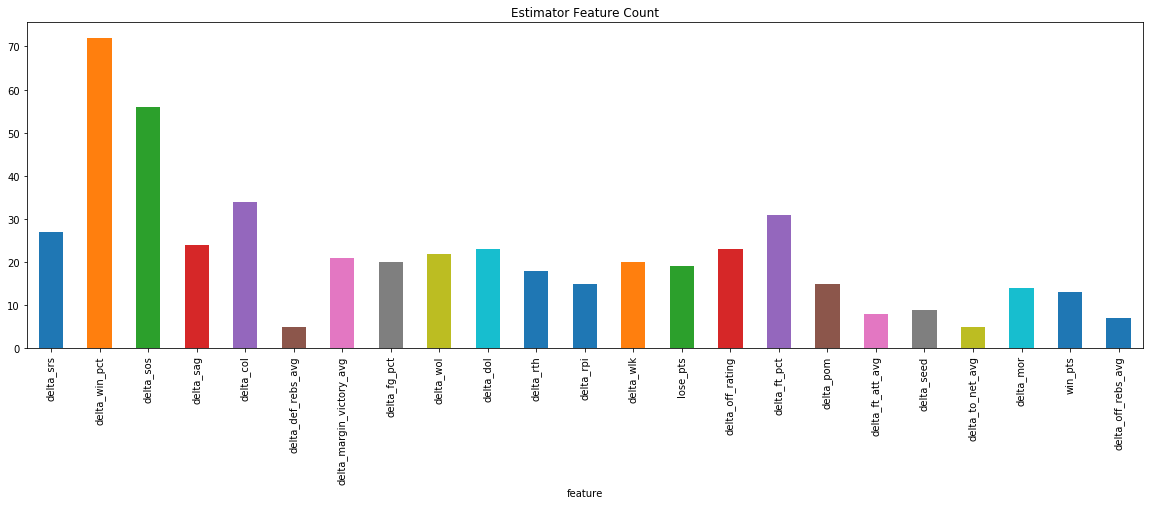

In [18]:
labels = list(feature_dict.keys())
values = list(feature_dict.values())


df = pd.DataFrame({'feature':labels, 'count':values})
ax = df.plot.bar(x='feature', y='count', legend=None)
ax.set_title('Estimator Feature Count')
ax.figure.set_size_inches(20,6)
print("Delta Win Count= ",df[df['feature']=='delta_win_pct']['count'])


Number of unique partitions=  29  out of  72  estimators


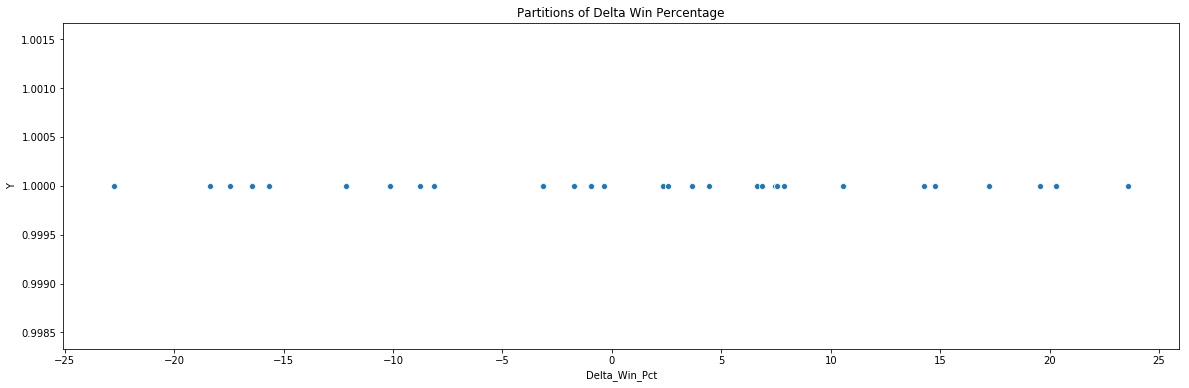

In [19]:
delta_win_partitions = threshold_dict['delta_win_pct']
delta_win_partitions = [i*100 for i in delta_win_partitions]

df_win = pd.DataFrame(columns=['Delta_Win_Pct','Y'])
df_win['Delta_Win_Pct'] = delta_win_partitions
df_win['Y'] = 1
df_win.sort_values(by='Delta_Win_Pct', inplace=True)
print("Number of unique partitions= ",df_win['Delta_Win_Pct'].unique().shape[0], " out of ", df_win.shape[0], ' estimators')

splot = sns.scatterplot(x='Delta_Win_Pct', y='Y', data=df_win)
splot.figure.set_size_inches(20,6)
splot.set_title('Partitions of Delta Win Percentage')
splot.set_xticks(np.arange(-25,30,5))
plt.show()

#### Why are there so many duplicate estimators (62%) for delta_win_pct estimators?

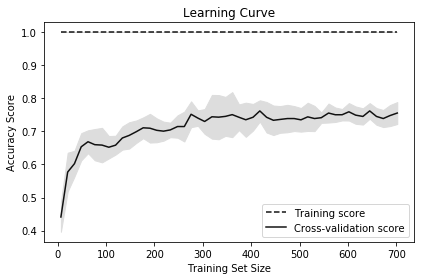

In [20]:
train_sizes, train_scores, test_scores = learning_curve(ada, X_train, y_train, cv=10, scoring='accuracy',
                                                        n_jobs=-1, 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Test

In [21]:
y_pred = ada.predict(X_test)
print("AdaBoost model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

AdaBoost model accuracy is 0.76


array([[63, 26],
       [21, 86]], dtype=int64)

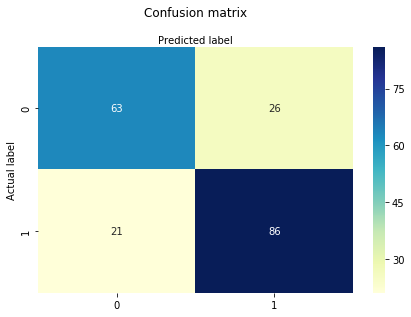

In [22]:
utils.display_confusion_matrix(y_test, y_pred)

In [23]:
prediction_probabilities = ada.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7602040816326531
Precision: 0.7678571428571429
Recall: 0.8037383177570093
Log loss=  0.6800980963270091


In [24]:
cross_val_scores = cross_val_score(ada, X,y, cv=10, scoring='accuracy')
print("Cross Validation average= ",cross_val_scores.mean())

Cross Validation average=  0.7709972648853356


In [25]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs
#test_games.head()

missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])
missed_predictions

Missed predictions=  47


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
816,2015,32,2015-03-21 00:00:00.0000000,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,71,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,68,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.731,73.861111,10.0,24.0,10.0,7.0,102.895825,22.0,14.11,9.72,0.611,70.0,65.0,0.436,0.686,75.550000,12.0,25.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,0,0,1,16.0,5.0,11.0,0.034,-2.0,-1.0,0.045,3.0,7.0,-4.0,0.306,10.241954,2.0,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.537897
734,2014,16,2014-03-28 00:00:00.0000000,4,Louisville,b795ddbc-baab-4499-8803-52e8608520ab,74,8,Kentucky,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,69,-1,2013,Lose,24.69,4.80,0.838,81.0,61.0,0.471,0.661,80.837838,13.0,24.0,10.0,10.0,100.200602,24.0,18.07,9.90,0.725,74.0,66.0,0.454,0.682,78.510000,14.0,26.0,11.0,4.0,94.255509,28.0,Atlantic Coast,Southeastern,2,2.0,11,8,16.0,2.0,13.0,19.0,1,18,16.0,33,19,22.0,17.0,25.0,17.0,26,0,0,0,20.0,8.0,12.0,0.017,-1.0,-2.0,-0.021,0.0,7.0,-7.0,0.113,5.945093,-4.0,-4,6.62,-5.10,-16,-14.0,-22,-11,-6.0,-15.0,-12.0,2.0,-25,1,0.521863
852,2016,64,2016-03-18 00:00:00.0000000,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,70,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,56,-1,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.673,85.394286,15.0,23.0,14.0,9.0,91.341006,27.0,9.23,-5.47,0.824,80.0,63.0,0.478,0.735,80.100000,11.0,23.0,12.0,9.0,99.875156,20.0,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,0,1,12.0,17.0,-5.0,-0.029,4.0,0.0,-0.062,5.0,3.0,2.0,-0.081,-8.534150,7.0,-11,12.38,15.25,-51,-49.0,-54,-93,-72.0,-27.0,-73.0,-52.0,-25,1,0.518346
656,2013,64,2013-03-22 00:00:00.0000000,2,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,78,15,Florida Gulf Coast,5326c079-3dc3-468f-a601-b776dd9c1e62,68,-1,2012,Lose,15.84,7.59,0.781,64.0,56.0,0.453,0.679,71.050000,9.0,20.0,12.0,7.0,90.077410,18.0,2.76,-2.07,0.703,72.0,66.0,0.462,0.675,79.767568,11.0,22.0,14.0,8.0,90.262248,19.0,Big East,Atlantic Sun,9,11.0,7,8,9.0,12.0,9.0,11.0,11,126,124.0,113,146,115.0,126.0,120.0,93.0,110,1,0,1,8.0,6.0,2.0,-0.009,-2.0,-2.0,0.004,5.0,6.0,-1.0,0.078,-0.184838,-1.0,-13,13.08,9.66,-117,-113.0,-106,-138,-106.0,-114.0,-111.0,-82.0,-99,1,0.517504
778,2014,64,2014-03-21 00:00:00.0000000,3,Duke,faeb1160-5d15-4f26-99fc-c441cf21fc7f,78,14,Mercer,a14b0057-8eb5-43d2-a33b-666196da933e,71,-1,2013,Lose,19.51,8.48,0.743,78.0,67.0,0.460,0.729,76.034286,11.0,22.0,9.0,6.0,102.585300,22.0,5.33,-3.42,0.750,78.0,66.0,0.476,0.736,77.705556,11.0,25.0,11.0,5.0,100.378923,21.0,Atlantic Coast,Southern,7,8.0,15,9,14.0,6.0,14.0,9.0,8,89,97.0,90,124,93.0,95.0,100.0,81.0,94,1,0,1,11.0,12.0,-1.0,-0.016,0.0,-3.0,-0.007,3.0,6.0,-3.0,-0.007,2.206377,1.0,-11,14.18,11.90,-82,-89.0,-75,-115,-79.0,-89.0,-86.0,-72.0,-86,1,0.515788
128,2005,64,2005-03-18 00:00:00.0000000,3,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,64,14,Bucknell,98d2123a-c7b9-4b5f-8a81-43f76d8537dc,63,-1,2004,Lose,20.68,10.8

In [26]:
feature_dictionary = utils.Feature_Dictionary()
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games, 
                                                                      x['season_t'], x['round'], x['team_t'] ), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        False  (L)
RTH                              2.00                              32.00        False  (L)
COL                              2.00                              40.00        Fal

Supporting Stat Count= 20  out of 26  stats.



                           North Carolina A&T                    Liberty     Stat Supports Winner
SAG                            242.00                             260.00         True  (L)
WLK                            223.00                             264.00         True  (L)
WOL                            219.00                             299.00         True  (L)
RTH                            246.00                             296.00         True  (L)
COL                            222.00                             293.00         True  (L)
POM                            226.00                             251.00         True  (L)
DOL                            221.00                             278.00         True  (L)
RPI                            213.00                             287.00         True  (L)
MOR                            234.00                             237.00         True  (L)
Allow PPG                       61.

816    [(SOS                              7.55       ...
734    [(RPI                             19.00       ...
852    [(Allow PPG                       66.00       ...
656    [(PPG                             64.00       ...
778    [(Allow PPG                       67.00       ...
128    [(Allow PPG                       65.00       ...
770    [(PPG                             67.00       ...
388    [(RPI                             32.00       ...
512    [(Net Turnover Avg                 4.00       ...
334    [(Seed                             14         ...
498    [(WOL                             28.00       ...
466    [(SAG                             20.00       ...
430    [(SOS                              8.61       ...
444    [(SAG                             18.00       ...
28     [(Seed                              3         ...
972    [(Seed                              3         ...
214    [(Allow PPG                       67.00       ...
548    [(SAG                   

In [27]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, feature_list),
                                               axis=1)

missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)


missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['game_index'] = missed_predictions.index
#missed_predictions.head()

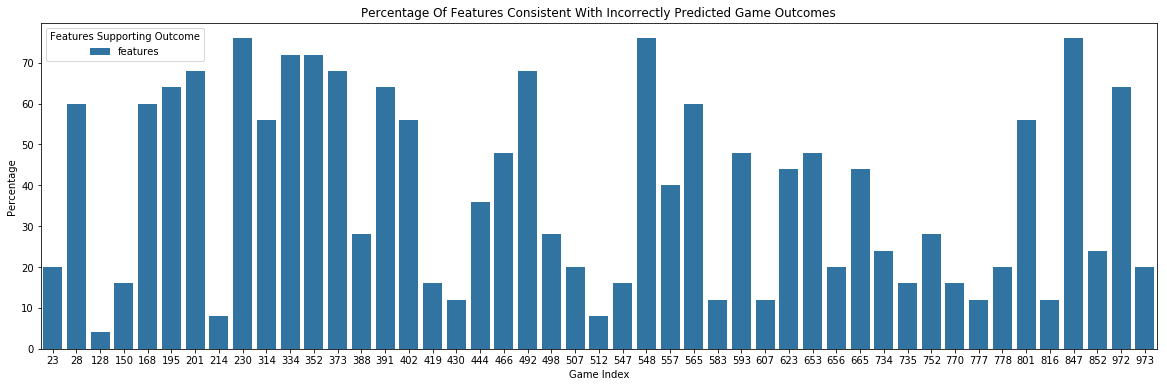

In [28]:
plot_missed_predictions_df = missed_predictions[['game_index','features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
#plot_missed_predictions_df.head()
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.

In [ ]:
plot_missed_predictions_df[plot_missed_predictions_df['value'] > 50]

##### Examine a missed prediction

In [ ]:
missed_prediction_index = 230
# get the list of features that suported the correct game oputcome
list_features =missed_predictions.loc[missed_prediction_index]['supporting_features']

In [ ]:
for item in list_features:
    print(item)

In [ ]:
missed_game_record = missed_predictions.loc[missed_prediction_index]
missed_game_record

In [ ]:
# staged_predict
missed_game = X.loc[missed_prediction_index].to_frame().T
missed_game
staged_predictions = ada.staged_predict(missed_game)
item_count =0
estimators=[]
values = []
for item in staged_predictions:
    # print(item_count, item)
    estimators.append(item_count)
    values.append(item[0])
    item_count += 1

In [ ]:
df = pd.DataFrame.from_dict({'Estimator':estimators,'Value':values})

decision_func = []
for item in ada.staged_decision_function(missed_game):
    decision_func.append(item[0])
    #print(item)
df['Decision'] = decision_func

predict_prob = []
for item in ada.staged_predict_proba(missed_game):
    predict_prob.append(item[0][0])
df['Predict_Prob'] = predict_prob 

In [ ]:
plt.plot('Estimator', 'Value', data= df, marker='', color='blue', label = 'Estimator')
plt.plot('Estimator', 'Decision', data= df, marker='', color='black', linestyle='dashed', label='Decision')
plt.plot('Estimator', 'Predict_Prob', data= df, marker='', color='red', linestyle='dashed', label='Probability')
plt.legend()

In [ ]:
# staged_score
staged_score_generator = ada.staged_score(missed_game,[1])
count =0
for item in staged_score_generator:
    print(count, item)
    count+=1

In [ ]:
#ada.estimator_errors_

In [ ]:
tree_stubs = ada.estimators_
stub_graph_data = []
for stub in tree_stubs:
    dot_data = tree.export_graphviz(stub,out_file=None, 
                                feature_names= list(X),filled=True, rounded=True, special_characters=True, proportion=False)
    stub_graph_data.append(dot_data)

graphviz.Source(stub_graph_data[0])


In [ ]:
graphviz.Source(stub_graph_data[1])

In [ ]:
graphviz.Source(stub_graph_data[5])

In [ ]:
graphviz.Source(stub_graph_data[332])

In [ ]:
stub_graph_data[5]

In [ ]:
 ada.estimators_[5]

In [ ]:
help(tree._tree.Tree)


In [ ]:
stub_5 =  ada.estimators_[5]
stub_5.classes_


In [ ]:
stub_5.tree_.value

In [ ]:
stub_5.tree_.weighted_n_node_samples

In [ ]:
stub_5.tree_.n_node_samples

In [ ]:
stub_5.tree_.impurity

### 2018 Tournament Predictions

In [29]:
test_year = 2018
X_season = feature_data[feature_data['season_t']== test_year]
y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season= X_season.drop(columns=['season_t'])
X_season.shape

(67, 25)

array([[21, 12],
       [ 7, 27]], dtype=int64)

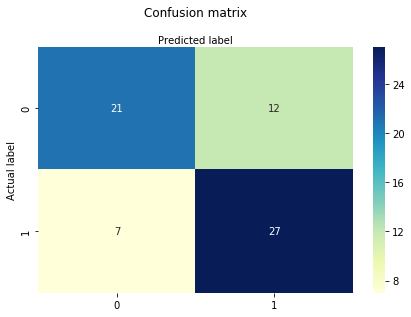

In [30]:
y_pred_season = ada.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)

In [31]:
prediction_probabilities =  ada.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.7164179104477612
Precision: 0.6923076923076923
Recall: 0.7941176470588235
Log loss=  0.678145811003392
